In [11]:
import csv
import math
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

In [2]:
def read_eos_geometry(filename):
    row_x = 1
    row_y = 2
    row_z = 3
    
    #Read CSV
    df = pd.read_csv(filename)
    
    matrix = df.to_numpy()

    #Extract cylindrical Coordinate
    r_cylindrical = np.sqrt(matrix[:, row_x]**2 + matrix[:, row_z]**2)
    theta_cylindrical = np.arctan2(matrix[:, row_y], matrix[:, row_x]) * -180 / np.pi + 180
    theta_degrees = theta_cylindrical * 180 / math.pi

    #Make df columns for cylindrical
    df['R Length'] = r_cylindrical
    df['Theta'] = theta_cylindrical
    df['Height'] = matrix[:, row_z]
    
    height = matrix[:, row_z]
    return df
    
read_eos_geometry('metaData.csv')

,PMT ID,X Position,Y Position,Z Position,R Length,Theta,Height
0,0,-681.965000,-390.919000,-991.096000,1203.057581,330.177612,-991.096000
1,1,-736.027000,-138.561000,-1116.930000,1337.635365,349.338543,-1116.930000
2,2,-697.283000,131.268000,-1026.750000,1241.136231,10.661517,-1026.750000
3,3,-681.965000,390.919000,-991.096000,1203.057581,29.822388,-991.096000
4,4,-477.826000,-546.650000,-1126.764000,1223.893295,311.156661,-1126.764000
...,...,...,...,...,...,...,...
236,236,285.518401,814.309562,1066.501827,1104.059285,109.322011,1066.501827
237,237,582.819656,-658.263043,1058.728087,1208.546198,228.478636,1058.728087
238,238,607.948537,-333.708127,1137.230690,1289.532887,208.762758,1137.230690
239,239,616.402121,0.000000,1163.639680,1316.817709,180.000000,1163.639680


In [3]:
#Credit to Eli Brunner-Huber for the bulk of this code
def read_annie_geometry(filename):
        
    # Step 1: Read the CSV file
    df = pd.read_csv('FullTankPMTGeometry.csv')
    
    # Step 2: Drop the first 4 rows and the last row
    df = df.iloc[4:-1]  # .iloc to slice, starting from the 5th row to the second-to-last row
    
    # Step 3: Select the first, fifth, sixth, and seventh columns
    selected_columns = df.iloc[:, [0, 4, 5, 6]]  # 0, 4, 5, and 6 are the indices for the first, fifth, sixth, and seventh columns
    
    # Step 4: Convert the selected columns to numeric values
    selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')  # Converts columns to numeric types
    selected_columns.columns = ['PMT ID', 'X Position', 'Y Position', 'Z Position']

    annie_geo = selected_columns
    # Step 5: Convert the selected columns to a matrix (numpy array)
    matrix = selected_columns.to_numpy()
    
    # Step 6: Add .1446 to the third column (index 2) and -1.681 to the fourth column (index 3)
    matrix[:, 2] += 0.1446  # Add .1446 to the third column (index 2)
    matrix[:, 3] += -1.681  # Add -1.681 to the fourth column (index 3)
    
    # Step 7: Calculate cylindrical coordinates
    # r = sqrt(x^2 + z^2)
    r_cylindrical = np.sqrt(matrix[:, 1]**2 + matrix[:, 3]**2)  # matrix[:, 1] is x, matrix[:, 3] is z

    # theta = atan2(z, x) (angle in the xy-plane)
    theta_cylindrical = np.arctan2(matrix[:, 3], matrix[:, 1])  # matrix[:, 3] is z, matrix[:, 1] is x
    
    # y = height (directly taken from the third column)
    height = matrix[:, 2]  # matrix[:, 2] is y, which is the height

    annie_geo['R Length'] = r_cylindrical
    annie_geo['Theta'] = theta_cylindrical
    annie_geo['Height'] = height

    return annie_geo

read_annie_geometry('FullTankPMTGeometry.csv')

,PMT ID,X Position,Y Position,Z Position,R Length,Theta,Height
4,333,-0.247685,-1.693962,1.603793,0.259439,-2.839422,-1.549362
5,334,-0.775424,-1.693962,1.508324,0.794418,-2.922482,-1.549362
6,335,-0.445549,-1.693962,1.802155,0.461728,2.876090,-1.549362
7,336,-0.577560,-1.685249,1.309961,0.686473,-2.570562,-1.540649
8,337,0.191253,-1.693962,2.460463,0.802583,1.330185,-1.549362
...,...,...,...,...,...,...,...
130,459,0.920851,0.864528,2.244969,1.079827,0.549519,1.009128
131,460,-0.266620,0.862612,2.728097,1.080509,1.820126,1.007212
132,461,0.549892,0.863099,2.608747,1.078469,1.035748,1.007699
133,462,0.264898,0.010389,2.724132,1.076242,1.322108,0.154989


In [4]:
#Use a PMT to get its position
def id_to_geo(id, geometry):
    id_list = geometry.iloc[:,0].to_numpy()
    for i in range(0, len(id_list)):
        if id_list[i] == id:
            return geometry.iloc[i,:].to_numpy()
        else:
            continue

In [5]:
#Read the data and make an array of events where each event has some hits of the formate [ID, Time, Charge]
def read_data(filename):
    #Load data
    df = pd.read_csv(filename)
    event_numbers = df.iloc[:,0]
    
    all_events = []
    #Loop by each row where row is event
    for i in range(0, len(event_numbers)):
        ncolumns = len(df.iloc[i,:])
        if(ncolumns > 4):
            print("WTF")
        Nhits = len(json.loads(df.iloc[i,1]))
        event = []
        #loop through the entries in a given column
        for j in range(0, Nhits-1):
            AHit = [json.loads(df.iloc[i,1])[j], json.loads(df.iloc[i,2])[j], json.loads(df.iloc[i,3])[j]]
            event.append(AHit)
        all_events.append(event)
    return all_events
    

In [24]:
#Takes a hit, geometry, and 'Canvas' and plots it on the canvas
def plot_hit(hit, collab_name, geometry, axes):
    ax0, ax1, ax2 = axes
    #Sort hard-coded values by collaboration
    if collab_name.lower() == 'eos':
        max_height = 1000
        min_height = -750
        end_cap_min_x = -900
        end_cap_max_x = 900
        end_cap_min_y = end_cap_min_x
        end_cap_max_y = end_cap_max_x
        x_ind = 1
        y_ind = 2
        height_ind = 3
        theta_ind = 5
    elif collab_name.lower() == 'annie':
        max_height = 1.1
        min_height = -1.3
        end_cap_min_x = 0.5
        end_cap_max_x = 2.75
        end_cap_min_y = -1
        end_cap_max_y = 1
        x_ind = 3
        y_ind = 1
        height_ind = 6
        theta_ind = 5
    else:
        print("Unsupported Collaboration Name")
        return 0
        
    #Load meta data
    event_pos = id_to_geo(hit[0], geometry)
    x_pos = event_pos[x_ind]
    y_pos = event_pos[y_ind]
    height = event_pos[height_ind]
    theta_cylindrical = event_pos[theta_ind]

    norm = mcolors.Normalize(vmin=0,vmax=1)

    #Create the figure
    if height < max_height and height > min_height:
        #Plot the Barrel
        ax1.scatter(theta_cylindrical, height, c=hit[2], norm=norm, cmap='viridis', marker='o', label='PMT locations', s=300)
        ax1.set_title('Unfolded Cylindrical Barrel View')
        ax1.set_xlabel('Theta (radians) - Angle Around the Cylinder')
        ax1.set_ylabel('Height (y) - Vertical Position in Tank')
        
    #Plot the Top End Cap
    elif height > max_height:
        ax0.set_xlim(end_cap_min_x, end_cap_max_x)
        ax0.set_ylim(end_cap_min_y, end_cap_max_y)
        ax0.scatter(x_pos, y_pos, c=hit[2], cmap='viridis', norm=norm, marker='o', label='PMT locations', s=360)
        ax0.set_title('Top End Cap Heat Map')
        ax0.set_xlabel('X Position (mm)')
        ax0.set_ylabel('Y position (mm)')

    elif height < min_height:
        #Plot the Bottom End Cap
        ax2.set_xlim(end_cap_min_x, end_cap_max_x)
        ax2.set_ylim(end_cap_min_y, end_cap_max_y)
        ax2.scatter(x_pos, y_pos, c=hit[2], cmap='viridis', norm=norm, marker='o', label='PMT locations', s=200)
        ax2.set_title('Bottom End Cap Heat Map')
        ax2.set_xlabel('X Position (mm)')
        ax2.set_ylabel('Y position (mm)')

# TO DO:
#    Add Flipbook functionality
#         Loop through each event and paste the plots to some sort of pdf
#     Once we have ANNIE data, condense the plotting parts (we just need to be able to use the intensity arrays)

In [26]:
#Sample ANNIE loop() to plot all events 
annie_data = read_data("annieLaser4692.csv")
annie_geo = read_annie_geometry("FullTankPMTGeometry.csv")

with PdfPages('test.pdf') as pdf:
    #Crashes around 62, does not have geometry for PMT 332  
    for i in tqdm(range(0,10)):
        #Initialize a "Canvas"
        fig = plt.figure(figsize=(10,10), layout="constrained")
        spec = fig.add_gridspec(2,2)
        ax0 = fig.add_subplot(spec[1,0])
        ax1 = fig.add_subplot(spec[0,:])
        ax2 = fig.add_subplot(spec[1,1])

        #Loop over each event per 
        for j in range(0, len(annie_data[i])):
            plot_hit(annie_data[i][j], 'annie', annie_geo, (ax0,ax1,ax2))
            print(annie_data[i][j][2])
            
        pdf.savefig(fig)
        plt.close()
  
            

  0%|                                                                                       | 0/10 [00:00<?, ?it/s]

0.000966943359375
0.003962109375000001
0.0020989746093750005
0.0022404785156250008
0.002900830078125
0.001674462890625
0.0020518066406250003
0.00400927734375
0.0012263671875000002
0.0024763183593749997
0.0036083496093750017
0.023489648437500003
0.0004716796875
0.0029479980468750007
0.002169726562500001
0.0015565429687499999
0.00099052734375
0.0008490234375
0.0019574707031250007
0.0015093749999999999
0.0025234863281250004
0.0015801269531249998
0.0024527343750000005
0.0022640625000000004
0.0019810546875000004
0.0024999023437500003
0.18881337890625002
0.023796240234375002
-0.00033017578124999996
0.001674462890625
0.001344287109375
0.00023583984375
0.001249951171875
0.003608349609374999
0.0044337890625
0.002971582031250001
0.0014622070312500003
0.001627294921875
0.0028300781250000014
0.002193310546875
0.0025942382812500003
0.001957470703125001
0.00136787109375
0.00099052734375
0.00033017578125
0.005023388671875001
0.008938330078125


 10%|███████▉                                                                       | 1/10 [00:01<00:11,  1.29s/it]

0.002381982421875
0.0014622070312500007
0.18577104492187502
0.028041357421874996
1.3877787807814457e-19
0.0019103027343749998
0.001627294921875
0.003183837890625001
0.004787548828125
0.0021697265625
0.0013914550781250002
0.0010376953125
0.004339453125
0.007570458984375


 20%|███████████████▊                                                               | 2/10 [00:02<00:07,  1.03it/s]

0.1825400390625
0.0229236328125
0.00165087890625
0.0017452148437500001
0.0014622070312500003
0.00042451171875
0.000259423828125
0.003042333984375
0.003962109375000002
0.0014150390624999998
0.0012735351562499998
0.001320703125
0.0036791015625000003
0.0077355468750000015
0.007098779296875003


 30%|███████████████████████▋                                                       | 3/10 [00:02<00:06,  1.15it/s]

0.18287021484375
0.023300976562500006
0.00188671875
0.0016037109375000003
0.0012263671875000002
0.0002830078125
0.0002830078125
0.0030187499999999997
0.0040564453125
0.0014857910156250002
0.0012735351562499998
0.00419794921875
0.007358203125000001


 40%|███████████████████████████████▌                                               | 4/10 [00:03<00:04,  1.22it/s]

0.0015801269531249998
0.18105424804687498
0.025588623046874998
-0.0004009277343749998
0.0019103027343749996
0.0015565429687499999
0.00035375976562500007
0.00014150390625
0.003089501953125
0.003938525390624999
0.001698046875
0.00117919921875
0.0011084472656250001
0.003962109375
0.007311035156250002


 50%|███████████████████████████████████████▌                                       | 5/10 [00:04<00:04,  1.10it/s]

0.002075390625
0.001957470703125
0.0011556152343750003
0.0016508789062500003
0.0018395507812499997
0.001297119140625
0.18678515625000003
0.028536621093750002
-0.00037734374999999997
0.00231123046875
0.0017923828125
0.00099052734375
0.0012735351562500003
0.003136669921875
0.004174365234375
0.000943359375
0.003561181640625
0.0066978515625000035


 60%|███████████████████████████████████████████████▍                               | 6/10 [00:05<00:03,  1.11it/s]

0.0026649902343749998
0.0016744628906249998
0.18770493164062502
0.026414062500000005
4.716796875000019e-05
0.0027593261718750002
0.0007546875
0.000495263671875
0.00089619140625
0.0037026855468750004
0.00485830078125
0.0025942382812500007
0.004268701171875003
0.00113203125
0.0012027832031250001
-4.716796874999998e-05
0.0043630371093750005
0.008018554687500004


 70%|███████████████████████████████████████████████████████▎                       | 7/10 [00:06<00:02,  1.10it/s]

0.0010848632812500002
0.001957470703125
0.18772851562499998
0.026154638671875
-0.0003301757812499999
0.0020046386718749996
0.0016272949218750002
0.0005660156250000001
0.00042451171875
0.0031130859374999993
0.0038441894531250007
0.001108447265625
0.0010612792968749999
0.004528124999999998
0.007759130859375002


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [00:07<00:01,  1.17it/s]

0.001391455078125
0.000966943359375
0.0043630371093750005
0.18834169921875
0.026862158203125003
2.358398437499999e-05
0.0028772460937499995
0.000636767578125
0.0004009277343750001
0.003466845703125
0.0047403808593750015
0.0021933105468750005
0.00127353515625
0.0011556152343750003
0.004009277343749999
0.006957275390625


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [00:08<00:00,  1.16it/s]

0.0021225585937500006
0.18376640625000001
0.030942187500000006
-0.00030659179687499936
0.0021933105468749997
0.0015329589843750002
0.0005895996093750001
0.00037734375
0.0019338867187499997
0.003325341796875001
0.00410361328125
0.002924414062500001
0.0038677734375000008
0.006391259765625002


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


 70%|█████████████████████████████████████████████████████▌                      | 141/200 [02:53<01:12,  1.23s/it]

KeyboardInterrupt



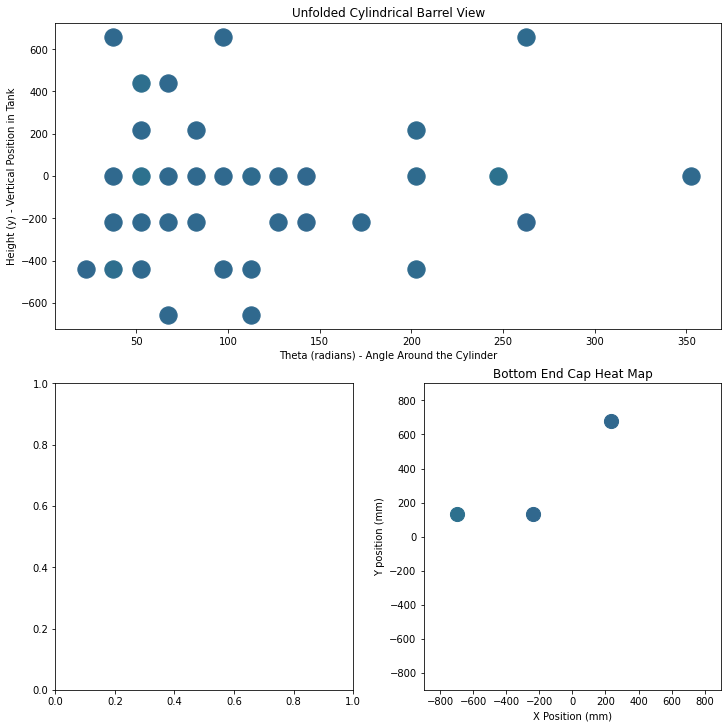

In [8]:
#Sample Eos loop() to plot all events 
eos_data = read_data("outputData.csv")
eos_geo = read_eos_geometry("eosMetaMap.csv")

with PdfPages('test_eos.pdf') as pdf:
    for i in tqdm(range(0,len(eos_data))):
        fig = plt.figure(figsize=(10,10), layout="constrained")
        spec = fig.add_gridspec(2,2)
        ax0 = fig.add_subplot(spec[1,0])
        ax1 = fig.add_subplot(spec[0,:])
        ax2 = fig.add_subplot(spec[1,1])
        
        for j in range(0, len(eos_data[i])):
            plot_hit(eos_data[i][j], 'eos', eos_geo, (ax0,ax1,ax2))
        # plt.show()
        pdf.savefig(fig)
        plt.close()
        

In [4]:
def plot_tank(df, intensity, collab_name, output_name):
    with PdfPages(output_name + '.pdf') as pdf:
        for event in tqdm(intensity):
            #Create the subsets for top, bottom and barrels
            barrel_height = []
            barrel_theta = []
            barrel_intensity = []
            
            top_x = []
            top_y = []
            top_intensity = []
        
            bot_x = []
            bot_y = []
            bot_intensity = []
        
            #Clunky mess for Eos Stuff
            if collab_name.lower() == 'eos':
                #load all the necessary meta data
                x_pos = df['X Position']
                y_pos = df['Y Position']
                height = df['Z Position']
                theta_cylindrical = df['Theta']
            
                #Sort the data by height
                for i in range(0, len(height)):
                    if height[i] < 1000 and height[i] > - 750:
                        barrel_height.append(height[i])
                        barrel_theta.append(theta_cylindrical[i])
                        barrel_intensity.append(event[i])
                    elif height[i] > 1000:
                        top_x.append(x_pos[i])
                        top_y.append(y_pos[i])
                        top_intensity.append(event[i])
                    elif height[i] < -750:
                        bot_x.append(x_pos[i])
                        bot_y.append(y_pos[i])
                        bot_intensity.append(event[i])
        
                 #Create the figure
                fig = plt.figure(figsize=(10,10), layout="constrained")
                spec = fig.add_gridspec(2,2)
            
                 #Plot the Barrel
                ax1 = fig.add_subplot(spec[0,:])
                plt.scatter(barrel_theta, barrel_height, c=barrel_intensity, cmap='viridis', marker='o', label='PMT locations', s=300)
                plt.title('Unfolded Cylindrical Barrel View')
                plt.xlabel('Theta (radians) - Angle Around the Cylinder')
                plt.ylabel('Height (y) - Vertical Position in Tank')
                
                #Plot the Top End Cap
                ax0 = fig.add_subplot(spec[1,0])
                plt.xlim(-900,900)
                plt.ylim(-900,900)
                plt.scatter(top_x, top_y, c=top_intensity, cmap='viridis', marker='o', label='PMT locations', s=360)
                plt.title('Top End Cap Heat Map')
                plt.xlabel('X Position (mm)')
                plt.ylabel('Y position (mm)')
                
                #Plot the Bottom End Cap
                ax2 = fig.add_subplot(spec[1,1])
                plt.scatter(bot_x, bot_y, c=bot_intensity, cmap='viridis', marker='o', label='PMT locations', s=200)
                plt.title('Bottom End Cap Heat Map')
                plt.xlabel('X Position (mm)')
                plt.ylabel('Y position (mm)')
               
                # Show the plot
                pdf.savefig(fig)
                #plt.show()
                plt.close()
        
            #Clunky mess for Annie Stuff
            elif collab_name.lower() == 'annie':
                #load all the necessary meta data
                beam_pos = df["Z Position"].to_numpy()
                perp_pos = df["X Position"].to_numpy()
                height = df["Height"].to_numpy()
                theta_cylindrical = df["Theta"].to_numpy()
        
                #Sort the data by height
                for i in range(0, len(height)):
                    if height[i] < 1.1 and height[i] > -1.3:
                        barrel_height.append(height[i])
                        barrel_theta.append(theta_cylindrical[i])
                        #barrel_intensity.append(intensity[i])
                    elif height[i] > 1.2:
                        top_x.append(beam_pos[i])
                        top_y.append(perp_pos[i])
                       # top_intensity.append(intensity[i])
                    elif height[i] < -1.3:
                        bot_x.append(beam_pos[i])
                        bot_y.append(perp_pos[i])
                       # bot_intensity.append(intensity[i])
        
                #Create the figure
                fig = plt.figure(figsize=(10,10), layout="constrained")
                spec = fig.add_gridspec(2,2)
        
                #Plot the Barrel
                ax1 = fig.add_subplot(spec[0,:])
                plt.scatter(barrel_theta, barrel_height, cmap='viridis', marker='o', label='PMT locations', s=300)
                plt.title('Unfolded Cylindrical Barrel View')
                plt.xlabel('Theta (radians) - Angle Around the Cylinder')
                plt.ylabel('Height (y) - Vertical Position in Tank')
                
                #Plot the Top End Cap
                ax0 = fig.add_subplot(spec[1,0])
                plt.scatter(top_x, top_y, cmap='viridis', marker='o', label='PMT locations', s=360)
                plt.title('Top End Cap Heat Map')
                plt.xlabel('Beam Position (m)')
                plt.ylabel('Perpendicular position (m)')
                
                #Plot the Bottom End Cap
                ax2 = fig.add_subplot(spec[1,1])
                plt.scatter(bot_x, bot_y, cmap='viridis', marker='o', label='PMT locations', s=200)
                plt.title('Bottom End Cap Heat Map')
                plt.xlabel('Beam Position (m)')
                plt.ylabel('Perpendicular position (m)')
               
                # Show the plot
                plt.show()
                
            else:
                print("Unsupported Collaboration Name")
                return 0

# TO DO:
#    Add Flipbook functionality
#         Loop through each event and paste the plots to some sort of pdf
#     Once we have ANNIE data, condense the plotting parts (we just need to be able to use the intensity arrays)

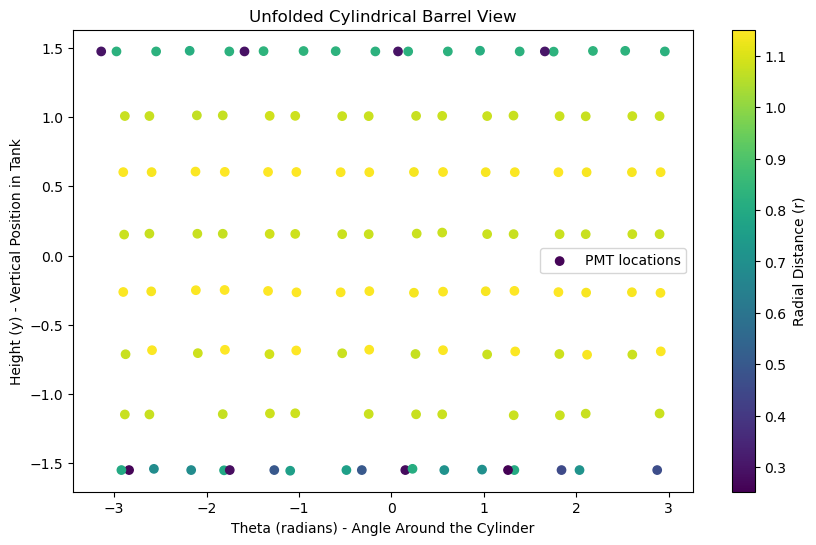

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('FullTankPMTGeometry.csv')


# Step 2: Drop the first 4 rows and the last row
df = df.iloc[4:-1]  # .iloc to slice, starting from the 5th row to the second-to-last row

# Step 3: Select the first, fifth, sixth, and seventh columns
selected_columns = df.iloc[:, [0, 4, 5, 6]]  # 0, 4, 5, and 6 are the indices for the first, fifth, sixth, and seventh columns

# Step 4: Convert the selected columns to numeric values
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')  # Converts columns to numeric types

# Step 5: Convert the selected columns to a matrix (numpy array)
matrix = selected_columns.to_numpy()

# Step 6: Add .1446 to the third column (index 2) and -1.681 to the fourth column (index 3)
matrix[:, 2] += 0.1446  # Add .1446 to the third column (index 2)
matrix[:, 3] += -1.681  # Add -1.681 to the fourth column (index 3)

# Step 7: Calculate cylindrical coordinates
# r = sqrt(x^2 + z^2)
r_cylindrical = np.sqrt(matrix[:, 1]**2 + matrix[:, 3]**2)  # matrix[:, 1] is x, matrix[:, 3] is z

# theta = atan2(z, x) (angle in the xy-plane)
theta_cylindrical = np.arctan2(matrix[:, 3], matrix[:, 1])  # matrix[:, 3] is z, matrix[:, 1] is x

# y = height (directly taken from the third column)
height = matrix[:, 2]  # matrix[:, 2] is y, which is the height

# Step 8: Plotting the unfolded cylindrical barrel

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot the PMT locations on the unfolded cylindrical barrel
# We use theta as the x-axis (representing the angle around the cylinder) and r as the y-axis (radial distance from the center)
plt.scatter(theta_cylindrical, height, c=r_cylindrical, cmap='viridis', marker='o', label='PMT locations')

# Add labels and title
plt.title('Unfolded Cylindrical Barrel View')
plt.xlabel('Theta (radians) - Angle Around the Cylinder')
plt.ylabel('Height (y) - Vertical Position in Tank')
plt.colorbar(label='Radial Distance (r)')
plt.legend()

# Show the plot
plt.show()
